In [1]:
import os
import numpy as np
import numba
import numba.cffi_support
import importlib
import pysundials_cffi
from pysundials_cffi import lambdify
import sympy as sy
import matplotlib.pyplot as plt

In [2]:
ndim = 2
nparam = 3

p = sy.MatrixSymbol('p', nparam, 1)
y = sy.MatrixSymbol('y', ndim, 1)

a, b, c = p
V, R = y

dV_dt = (V - V**3 / 3 + R) * c
dR_dt = (V - a + b * R) / -c

dy = sy.Matrix([dV_dt, dR_dt])

In [3]:
import sympy.codegen.rewriting

In [4]:
def optimize(expr):
    return sympy.codegen.rewriting.optimize(
        expr, sympy.codegen.rewriting.optims_c99)

In [5]:
dy = dy.applyfunc(optimize)
dy

Matrix([
[    (-y[0, 0]**3/3 + y[0, 0] + y[1, 0])*p[2, 0]],
[-(-p[0, 0] + p[1, 0]*y[1, 0] + y[0, 0])/p[2, 0]]])

In [6]:
# Create native function using numba
dy_pre, dy_comp = lambdify.lambdify_consts('_rhs', [], [p, y], dy)

In [7]:
v = sy.MatrixSymbol('v', ndim, 1)
Jv = dy.jacobian(y) * sy.Matrix(v)
Jv = Jv.applyfunc(optimize)
Jv

Matrix([
[(1 - y[0, 0]**2)*p[2, 0]*v[0, 0] + p[2, 0]*v[1, 0]],
[        -p[1, 0]*v[1, 0]/p[2, 0] - v[0, 0]/p[2, 0]]])

In [8]:
# We also have dy in the matrix-vector product. Can we use it somehow?
Jv_pre, Jv_comp = lambdify.lambdify_consts('_jacobian_prod', [], [p, y, v], Jv)

In [9]:
J = dy.jacobian(y)
J = J.applyfunc(optimize)
J

Matrix([
[(1 - y[0, 0]**2)*p[2, 0],          p[2, 0]],
[              -1/p[2, 0], -p[1, 0]/p[2, 0]]])

In [10]:
J_pre, J_comp = lambdify.lambdify_consts('_jacobian', [], [p, y], J)

In [11]:
df_dp = dy.jacobian(p)
df_dp = df_dp.applyfunc(optimize)
df_dp

Matrix([
[        0,                0,                 -y[0, 0]**3/3 + y[0, 0] + y[1, 0]],
[1/p[2, 0], -y[1, 0]/p[2, 0], (-p[0, 0] + p[1, 0]*y[1, 0] + y[0, 0])/p[2, 0]**2]])

In [12]:
df_dp_pre, df_dp_comp = lambdify.lambdify_consts('_df_dp', [], [p, y], df_dp)

In [13]:
user_dtype = np.dtype([('p', (np.float64, (nparam,)))], align=True)
user_ndtype = numba.from_dtype(user_dtype)
user_ndtype

user_ndtype_p = numba.types.CPointer(user_ndtype)
user_data = np.zeros((1,), dtype=user_dtype)[0]
user_data['p'] = 1
user_data

([1., 1., 1.],)

In [14]:
@numba.njit()
def rhs(t, y, out, user_data):
    p = user_data.p.reshape(-1, 1)
    # TODO The optimizer doesn't see to be able
    # to optimize the malloc away. We could
    # extend lambdify to take an out argument.
    out[:] = dy_comp((), p, y.reshape(-1, 1))[:, 0]
    return 0

@numba.njit
def jacobian_prod(t, v, y, fy, out, user_data):
    p = user_data.p
    out[:] = Jv_comp(
        (),
        p.reshape((-1, 1)),
        y.reshape((-1, 1)),
        v.reshape((-1, 1))
    )[:, 0]
    return 0

@numba.njit
def jacobian(t, y, fy, out, user_data):
    p = user_data.p
    out[:, :] = J_comp((), p.reshape((-1, 1)), y.reshape((-1, 1)))
    return 0

In [15]:
pysundials_cffi = importlib.reload(pysundials_cffi)
ffi = pysundials_cffi._ffi.ffi
lib = pysundials_cffi._ffi.lib

In [16]:
numba.cffi_support.register_module(pysundials_cffi._ffi)
numba.cffi_support.register_type(
    pysundials_cffi._ffi.ffi.typeof('N_Vector').item,
    numba.types.Opaque('N_Vector'))
numba.cffi_support.register_type(
    pysundials_cffi._ffi.ffi.typeof('SUNMatrix').item,
    numba.types.Opaque('SUNMatrix'))

In [17]:
ndim = 2
y0 = pysundials_cffi.nvector.empty(ndim)
y0.data[:] = 0

In [18]:
abstol = pysundials_cffi.nvector.empty(ndim)
abstol.data[:] = [1e-8, 1e-8]
reltol = 1e-8

In [19]:
ode = lib.CVodeCreate(lib.CV_BDF)

In [20]:
user_data_p = ffi.cast('void *', ffi.addressof(ffi.from_buffer(user_data.data)))

In [21]:
N_VGetArrayPointer_Serial = lib.N_VGetArrayPointer_Serial

func_type = numba.cffi_support.map_type(ffi.typeof('CVRhsFn'))
func_type = func_type.return_type(*(func_type.args[:-1] + (user_ndtype_p,)))
func_type

@numba.cfunc(func_type)
def rhs_wrapper(t, y_, out_, user_data_):
    y_ptr = N_VGetArrayPointer_Serial(y_)
    out_ptr = N_VGetArrayPointer_Serial(out_)
    y = numba.carray(y_ptr, (ndim,))
    out = numba.carray(out_ptr, (ndim,))
    user_data = numba.carray(user_data_, (1,))[0]
    p = user_data.p
    
    return rhs(t, y, out, user_data)

In [22]:
SUNDenseMatrix_Data = lib.SUNDenseMatrix_Data

func_type = numba.cffi_support.map_type(ffi.typeof('CVLsJacFn'))
args = list(func_type.args)
args[4] = user_ndtype_p
func_type = func_type.return_type(*args)
func_type

@numba.cfunc(func_type)
def Jac(t, y_, fy_, out_, user_data_, tmp1_, tmp2_, tmp3_):
    y_ptr = N_VGetArrayPointer_Serial(y_)
    out_ptr = SUNDenseMatrix_Data(out_)
    fy_ptr = N_VGetArrayPointer_Serial(fy_)
    y = numba.carray(y_ptr, (ndim,))
    out = numba.farray(out_ptr, (ndim, ndim))
    fy = numba.carray(fy_ptr, (ndim,))
    user_data = numba.carray(user_data_, (1,))[0]
    p = user_data.p
    
    return jacobian(t, y, fy, out, user_data)

In [23]:
# Not used
SUNDenseMatrix_Data = lib.SUNDenseMatrix_Data

func_type = numba.cffi_support.map_type(ffi.typeof('CVLsJacTimesVecFn'))
args = list(func_type.args)
args[-2] = user_ndtype_p
func_type = func_type.return_type(*args)
func_type

@numba.cfunc(func_type)
def jac_prod_wrapper(v_, out_, t, y_, fy_, user_data_, tmp_):
    v_ptr = N_VGetArrayPointer_Serial(v_)
    y_ptr = N_VGetArrayPointer_Serial(y_)
    #out_ptr = SUNDenseMatrix_Data(out_)
    out_ptr = N_VGetArrayPointer_Serial(out_)
    fy_ptr = N_VGetArrayPointer_Serial(fy_)
    v = numba.carray(v_ptr, (ndim,))
    y = numba.carray(y_ptr, (ndim,))
    out = numba.carray(out_ptr, (ndim,))
    fy = numba.carray(fy_ptr, (ndim,))
    user_data = numba.carray(user_data_, (1,))[0]
    p = user_data.p
    
    return jacobian_prod(t, v, y, fy, out, user_data)

In [24]:
print(lib.CVodeInit(ode, rhs_wrapper.cffi, 0, y0._c_ptr))
lib.CVodeSVtolerances(ode, reltol, abstol._c_ptr)

0


0

In [25]:
A = lib.SUNDenseMatrix(ndim, ndim)

In [26]:
linsolver = lib.SUNLinSol_Dense(y0._c_ptr, A)

In [27]:
lib.CVodeSetLinearSolver(ode, linsolver, A)

0

In [28]:
lib.CVodeSetJacFn(ode, Jac.cffi)

0

In [29]:
lib.CVodeSetUserData(ode, user_data_p)

0

In [30]:
yS = lib.N_VCloneVectorArray(nparam, y0._c_ptr)

In [31]:
vecs = [pysundials_cffi.nvector.Vector(yS[i], None) for i in range(nparam)]
for vec in vecs:
    vec.data[:] = 0
np.array([vec.data for vec in vecs])

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [32]:
func_type = numba.cffi_support.map_type(ffi.typeof('CVSensRhsFn'))
args = list(func_type.args)
args[-3] = user_ndtype_p
func_type = func_type.return_type(*args)
func_type

@numba.cfunc(func_type)
def sens_rhs(n_params, t, y_, ydot_, yS_, out_, user_data_, tmp1_, tmp2_):
    y_ptr = N_VGetArrayPointer_Serial(y_)
    y = numba.carray(y_ptr, (ndim,))
    y_dot_ptr = N_VGetArrayPointer_Serial(ydot_)
    ydot = numba.carray(y_dot_ptr, (ndim,))
    
    out = []
    for i in range(n_params):
        out_i_ptr = N_VGetArrayPointer_Serial(out_[i])
        out_i = numba.carray(out_i_ptr, (ndim,))
        out.append(out_i)

    yS = []
    for i in range(n_params):
        yS_i_ptr = N_VGetArrayPointer_Serial(yS_[i])
        yS_i = numba.carray(yS_i_ptr, (ndim,))
        yS.append(yS_i)
        
    user_data = numba.carray(user_data_, (1,))[0]
    p = user_data.p
    
    df_dp = df_dp_comp((), p.reshape((-1, 1)), y.reshape((-1, 1)))

    for i in range(n_params):
        s = yS[i]
        ySdot = out[i]

        jacobian_prod(t, s, y, None, ySdot, user_data)
        ySdot[:] += df_dp[:, i]
    
    return 0

In [33]:
assert 0 == lib.CVodeSensInit(ode, nparam, lib.CV_STAGGERED, sens_rhs.cffi, yS)
assert 0 == lib.CVodeSensEEtolerances(ode)
assert 0 == lib.CVodeSetSensErrCon(ode, 1)

In [34]:
pbar = np.ones(nparam)

In [35]:
NULL_D = ffi.cast('double *', 0)
NULL_I = ffi.cast('int *', 0)
pbar_p = ffi.cast('double *', ffi.addressof(ffi.from_buffer(pbar.data)))

In [36]:
lib.CVodeSetSensParams(ode, NULL_D, pbar_p, NULL_I)

0

In [37]:
time_p = ffi.new('double*')
time_p[0] = 0.

In [38]:
tvals = np.linspace(0, 10)
y_vals = []
sens_vals = []

user_data['p'][...] = [-0.2, 0.3, 0.5]

In [39]:
user_data

([-0.2,  0.3,  0.5],)

In [40]:
%%timeit
y_vals.clear()
sens_vals.clear()

y0.data[:] = [0.5, 0.6]
for vec in vecs:
    vec.data[:] = 0

lib.CVodeReInit(ode, 0, y0._c_ptr)
for t in tvals:
    retval = -1
    while retval == -1:
        retval = lib.CVode(ode, t, y0._c_ptr, time_p, lib.CV_NORMAL)
    y_vals.append(y0.data.copy())
    lib.CVodeGetSens(ode, time_p, yS)
    sens_vals.append(np.array([vec.data.copy() for vec in vecs]).T)

2.03 ms ± 67.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
import matplotlib.pyplot as plt

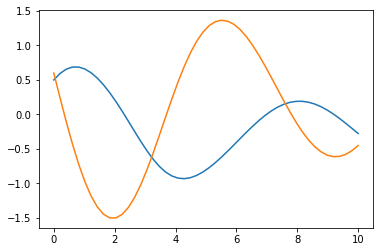

In [42]:
plt.plot(tvals, np.array(y_vals)[:, 0])
plt.plot(tvals, np.array(y_vals)[:, 1])

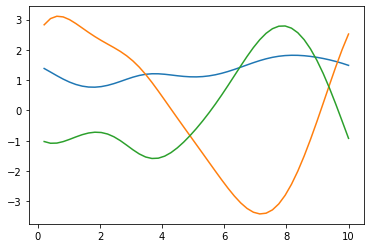

In [43]:
plt.plot(tvals, np.array(sens_vals)[:, 0, 0])
plt.plot(tvals, np.array(sens_vals)[:, 0, 1])
plt.plot(tvals, np.array(sens_vals)[:, 0, 2])

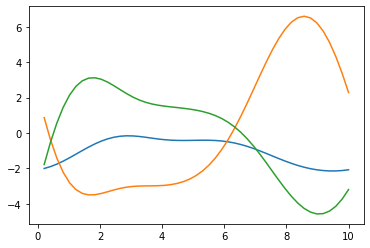

In [44]:
plt.plot(tvals, np.array(sens_vals)[:, 1, 0])
plt.plot(tvals, np.array(sens_vals)[:, 1, 1])
plt.plot(tvals, np.array(sens_vals)[:, 1, 2])

In [45]:
num_evals_p = ffi.new('long*')
num_evals_p[0] = 0

In [46]:
lib.CVodeGetNumRhsEvals(ode, num_evals_p)
num_evals_p[0]

610

In [47]:
lib.CVodeGetNumSteps(ode, num_evals_p)
num_evals_p[0]

295

In [48]:
time_p[0]

10.0

In [49]:
from scipy import integrate

In [50]:
def rhs_(t, y):
    out = np.empty_like(y)
    assert rhs(t, y, out, user_data) == 0
    return out

In [51]:
def jac_(t, y):
    out = np.empty((ndim, ndim))
    assert jacobian(t, y, None, out, user_data) == 0
    return out

In [52]:
from scipy import integrate

In [53]:
%%timeit
out = integrate.solve_ivp(
    rhs_,
    jac=jac_,
    t_span=(0, tvals.max()),
    t_eval=tvals, y0=np.array([0.5, 0.6]), method='BDF',
    rtol=reltol, atol=abstol.data.copy())

43.8 ms ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
out = integrate.solve_ivp(
    rhs_,
    jac=jac_,
    t_span=(0, tvals.max()),
    t_eval=tvals, y0=np.array([0.5, 0.6]), method='BDF',
    rtol=reltol, atol=abstol.data.copy())

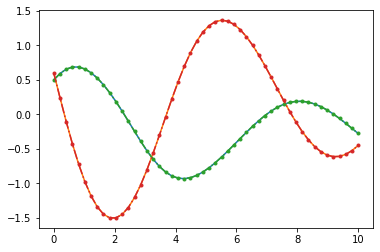

In [55]:
plt.plot(tvals, out.y[0, :])
plt.plot(tvals, out.y[1, :])

plt.plot(tvals, np.array(y_vals)[:, 0], '.-.')
plt.plot(tvals, np.array(y_vals)[:, 1], '.-.')

In [56]:
out

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 414
     njev: 1
      nlu: 36
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])
 t_events: None
        y: array([[ 0.5       ,  0.59330775,  0.6558635 ,  0.68691887,  0.68730437,